In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sympy as sp
from sympy import *
import math
import re



with open("equation.txt") as f:
    for line in f:
        e = line #e is the equation

#pe is the proper equation format in np
pe = e

functions = ['sin', 'cos', 'tan', 'exp', 'log', 'sqrt']

for f in functions:
    pe = re.sub(rf'\b{f}\b', f'np.{f}', pe)
pe = pe.replace('^', '**')
pe = re.sub(r'\be\b', 'np.e', pe)


se = pe.replace('np.', '')

print(e)
print(pe)
print(se)

def make_function(ex): #pe
    allowed_names = {
        'np': np,
        'x': None  # placeholder, replaced at call time
    }

    def f(x):
        local_dict = allowed_names.copy()
        local_dict['x'] = x
        return eval(ex, {"__builtins__": {}}, local_dict)

    return f



x * log(x) + sin(x)
x * np.log(x) + np.sin(x)
x * log(x) + sin(x)


In [2]:
x = sp.symbols('x')
f = sp.sympify(se)

def find_taylor(order, x0):
    taylors = f.subs(x,x0)
    diffed = f
    for i in range(1, order):
        diffed = diffed.diff(x)
        taylors += diffed.subs(x,x0) * 1/(factorial(i))*((x-x0)**i)
    return taylors

def compute_taylor(order, x_values, x0):
    taylor_np = sp.lambdify(x, find_taylor(order, x0), "numpy")
    y = taylor_np(x_values)
    if np.isscalar(y):
        y = np.full_like(x_values, y, dtype=float)
    return y

print(find_taylor(3, 0.00000001))

-16.4206807439524*x + 50000000.0*(x - 1.0e-8)**2 - 9.99999999999998e-9


/var/folders/zs/4103krws4jxgvc42d5j93xdc0000gn/T/ipykernel_27778/2296052800.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


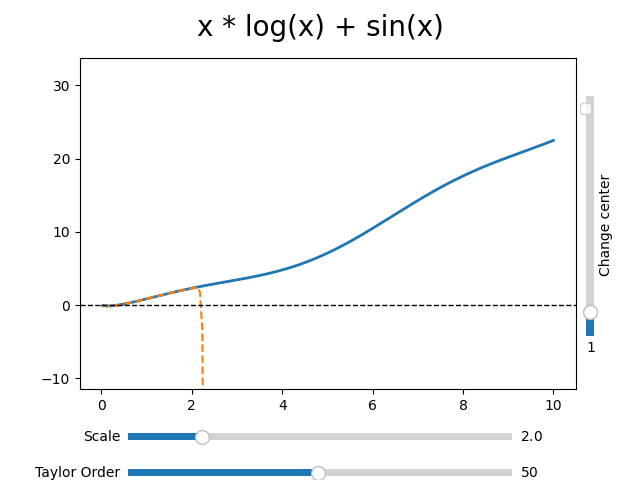

In [3]:
from matplotlib.widgets import Slider
from sympy.calculus.util import continuous_domain
from sympy import S
%matplotlib widget


current_order = 50
x_vals = np.linspace(-10, 10, 400)

domain = continuous_domain(f, x, S.Reals)
mask = np.array([domain.contains(val) for val in x_vals], dtype=bool)
x_vals_masked = x_vals[mask]


original_function = make_function(pe) #The Original
centered = 0
if(not domain.contains(0)):
    centered = 1

taylor_np = sp.lambdify(x, find_taylor(current_order, centered), "numpy") #Taylor's Theorem

#x and y values of the plotted lines

y_np = original_function(x_vals_masked)
y_sym = taylor_np(x_vals_masked)

fig, ax = plt.subplots()
orig_line, = plt.plot(x_vals_masked, y_np, label="Original", linewidth=2)
taylor_line, = plt.plot(x_vals_masked, y_sym, label="Taylor Expansion", linestyle="--")


# y limits
padding = 0.5
y_min = np.nanmin(y_np)
y_max = np.nanmax(y_np)
yrange = y_max - y_min

if(yrange == 0):
    yrange = 1

plt.ylim(
    y_min - padding * yrange,
    y_max + padding * yrange
)

# --- slider for Taylor ---
ax_sliderT = plt.axes([0.2, 0, 0.6, 0.03])
sliderT = Slider(
    ax=ax_sliderT,
    label="Taylor Order",
    valmin=1,
    valmax=100,
    valinit=current_order,
    valstep=1
)

def update_plot_taylor(val):
    global current_order
    current_order = int(val)

    x_current = orig_line.get_xdata()
    y_taylor = compute_taylor(current_order, x_current, centered)

    taylor_line.set_xdata(x_current)
    taylor_line.set_ydata(y_taylor)
    fig.canvas.draw_idle()

sliderT.on_changed(update_plot_taylor)


# --- slider for Scale ---
ax_sliderS = plt.axes([0.2, 0.075, 0.6, 0.03])
sliderS = Slider(
    ax=ax_sliderS,
    label="Scale",
    valmin=0.1,
    valmax=10,
    valinit=2,
    valstep=0.1
)

def update_plot_scale(val):
    x_new = np.linspace(-5 * val, 5 * val, 400)

    mask = np.array([domain.contains(val) for val in x_new], dtype=bool)
    x_new = x_new[mask]

    y_orig_new = original_function(x_new)
    y_taylor_new = compute_taylor(current_order, x_new, centered)

    orig_line.set_xdata(x_new)
    orig_line.set_ydata(y_orig_new)

    taylor_line.set_xdata(x_new)
    taylor_line.set_ydata(y_taylor_new)

    ax.set_xlim(x_new.min(), x_new.max())
    ax.relim()
    ax.autoscale_view()

    fig.canvas.draw_idle()

sliderS.on_changed(update_plot_scale)


# --- Slider for a ---
ax_sliderA = plt.axes([0.91, 0.3, 0.025, 0.5])
sliderA = Slider(
    ax=ax_sliderA,
    label="Change center",
    valmin=0,
    valmax=10,
    valinit=centered,
    valstep=1,
    orientation="vertical"
)
sliderA.label.set_rotation('vertical')
sliderA.label.set_position((1.5, 0.25))



def update_plot_center(val):
    global centered
    centered = float(val)
    if(not domain.contains(centered)):
        centered = float(domain.start) + 1E15

    x_current = orig_line.get_xdata()
    y_taylor = compute_taylor(current_order, x_current, centered)

    taylor_line.set_xdata(x_current)
    taylor_line.set_ydata(y_taylor)
    fig.canvas.draw_idle()

sliderA.on_changed(update_plot_center)

# --- Display ---
ax.axhline(0, color="black", linewidth=1, linestyle="--")
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False


plt.suptitle(e, y = 0.97, fontsize=20)
plt.subplots_adjust(bottom=0.19)


plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

update_plot_scale(2)
fig.canvas.draw_idle()